In [1]:
import numpy as np
import scipy
from scipy.optimize import NonlinearConstraint, minimize

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture

import pickle
from pathlib import Path

In [2]:
def a1_hyperplane(x):
    return x[0] * (4 - 1.26) + x[1] * (0 - 3.79)

def a2_hyperplane(x):
    return x[0] * (1.26 + 3.2) + x[1] * (3.79 - 2.39)

def a3_hyperplane(x):
    return x[0] * (-3.2 + 3.28) + x[1] * (2.39 + 2.28)

def a4_hyperplane(x):
    return x[0] * (-3.28 - 1.13) + x[1] * (-2.28 + 3.83)

def a5_hyperplane(x):
    return x[0] * (1.13 - 4) + x[1] * (-3.83 - 0)

def get_pentagon_feasible_set():
    ''' Generates the A matrix and b vector by matrix inversion.'''
    X1 = np.array([
        [4, 0],
        [1.26, 3.79],
    ])
    X2 = np.array([
        [1.26, 3.79],
        [-3.2, 2.39],
    ])
    X3 = np.array([
        [-3.2, 2.39],
        [-3.28, -2.28],
    ])
    X4 = np.array([
        [-3.28, -2.28],
        [1.13, -3.83],
    ])
    X5 = np.array([
        [1.13, -3.83],
        [4, 0],
    ])
    Xs = [X1, X2, X3, X4, X5]
    ones = np.array([1, 1])

    A_mat = []
    b_vec = -1 * np.ones(5)
    for X in Xs:
        A_mat.append(np.linalg.solve(X, ones))
    A_mat = np.array(A_mat)
    A_mat = -1 * A_mat
    print(A_mat)
    print(b_vec)
    return A_mat, b_vec

In [3]:
def direction_sample_helper(con):
    ''' Samples a random point from the unit ball then checks with
    the a vector that con'pt > 0'''
    wrong_direction = 1
    while wrong_direction == 1:
        pt = np.random.rand(2) - 0.5
        pt = pt / np.linalg.norm(pt)
        if np.dot(con, pt) >= 0:
            wrong_direction = 0
    return pt


def direction_sample(A_mat, bd_pt):
    ''' First identifies the relevant constraint on the boundary,
    then calls sample helper.'''
    ind = list(np.isclose(np.dot(A_mat, bd_pt), -1)).index(True)
    con = A_mat[ind]
    return direction_sample_helper(con)


def get_next_bd_pt(A_mat, bd_pt, dir_pt):
    ''' First removes boundary constraints, then finds nearest
    boundary.'''
    weights = np.array([(-1 - np.dot(ai, bd_pt)) / np.dot(ai, dir_pt) for ai in A_mat])
    weights[weights <= 0] = 99
    weight = min(weights)

    return bd_pt + weight * dir_pt


def shake_n_bake(A_mat, init_pt, n=10, scale=2):
    '''
    1. randomly sample direction vector (r)
    2. randomly sample magnitude (xi)
    3. add infeasible point (y - xi * r, y)
    4. get next boundary point
    '''
    dataset = []
    bd_pt = init_pt
    while len(dataset) < n:
        r = direction_sample(A_mat, bd_pt)
        xi = np.random.exponential(scale=scale)
        infeas_pt = bd_pt - xi * r
        dataset.append((infeas_pt, bd_pt))
        bd_pt = get_next_bd_pt(A_mat, bd_pt, r)
    return dataset

In [1]:
def experiment_pentagon(n_samples=500):
    ''' Run the experiment.
    '''
    A_mat, b_vec = get_pentagon_feasible_set()
    init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])
    dataset = shake_n_bake(A_mat, init_pt, n=n_samples, scale=5)
    infeas_pts, bd_pts = zip(*dataset)
    x, y = zip(*infeas_pts)
    xs = [
        # x[:5],
        x[:50],
        x[:500],
    ]
    ys = [
        # y[:5],
        y[:50],
        y[:500],
    ]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
    for i, ax in enumerate(axs):
        # plot the polyhedron lines
        xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
        ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
        ax.plot(
            xpoly, ypoly, markersize=0, color='black', 
        )

        # then plot sampled points
        ax.scatter(
            xs[i], ys[i],
        )

        ax.tick_params(direction='in')
        ax.grid(True, ls='--', alpha=0.1)
        ax.set(
            xlabel='x', 
            ylabel='y', 
            xlim=(-10, 10),
            xticks=[-10, -5, 0, 5, 10],
            ylim=(-10, 10),
            yticks=[-10, -5, 0, 5, 10],
        )
    return fig, axs

fig, axs = experiment_pentagon()

NameError: name 'get_pentagon_feasible_set' is not defined

In [5]:
def check_hidden_feasibility(pt):
    ''' Three constraints:
        y >= 0.25 x^2 - 3
        y >= x - 3
        y <= 0.5 (x - 1)^2 + 2.5
    '''
    if pt[1] < 0.25 * ( pt[0] ** 2 ) - 3:
        return 0
    elif pt[1] < pt[0] - 3:
        return 0
    elif pt[1] > -0.5 * ( ( pt[0] + 0.5 ) ** 2 ) + 2.5:
        return 0
    else:
        return 1

def generate_feasible_pts(n_samples=200):
    xs, ys = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
    feas = np.zeros((len(xs), len(ys)))
    feasible_pts = []
    for i in range(len(xs)):
        for j in range(len(ys)):
            feas[i, j] = check_hidden_feasibility([xs[i, j], ys[i, j]])
            if feas[i, j] == 1:
                feasible_pts.append([xs[i, j], ys[i, j]])
    feasible_pts = np.array(feasible_pts)
    idx = np.random.randint(len(feasible_pts), size=n_samples)
    sampled_pts = feasible_pts[idx, :].T
    return sampled_pts


def get_gmm_contour(mdl, min_pred=0.2):
    ''' Takes a trained model and generates the contour
    '''
    xs, ys = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    pred_feas = np.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            pred_feas[i, j] = -1 / mdl.score_samples([np.array([xs[i, j], ys[i, j]])])
            pred_feas[pred_feas > min_pred] = 1
            pred_feas[pred_feas < min_pred] = 0
    return xs, ys, pred_feas


def get_mdl_contour(mdl):
    ''' Takes a trained model and generates the contour
    '''
    xs, ys = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    pred_feas = np.zeros((len(xs), len(ys)))
    real_feas = np.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            pred_feas[i, j] = mdl.predict([np.array([xs[i, j], ys[i, j]])])
            real_feas[i, j] = check_hidden_feasibility([xs[i, j], ys[i, j]])
    return xs, ys, pred_feas, real_feas


def haussdorf(feas, infeas, inner=np.min, outer=np.min):
    inner_dist = np.zeros(len(feas))
    for ix in range(len(feas)):
        inner_dist[ix] = inner([np.linalg.norm(feas[ix] - y) for y in infeas])
    return outer(inner_dist)


def projection_algorithm(A_mat, b_vec, feasible_pts, n_samples=200, scale=2):
    feasible_pts = feasible_pts.T
    m, n = A_mat.shape
    infeas_pts = []
    for ix in range(n_samples):
        idx = np.random.randint(0, len(feasible_pts))
        pt = feasible_pts[idx]
        row_idx = np.random.randint(0, m)
        ai, bi = A_mat[row_idx], b_vec[row_idx]
        xi_lb = ( bi - np.dot(ai, pt) ) / ( np.linalg.norm(ai) ** 2 )
        xi = xi_lb - np.random.exponential(scale=scale)
        infeas_pts.append(pt + xi * ai)
    return infeas_pts

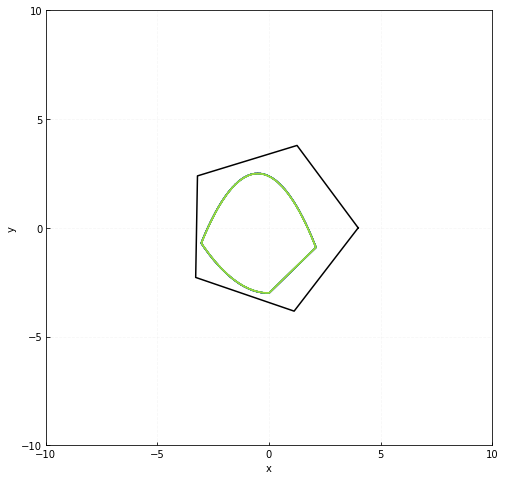

In [6]:
def generate_feasible_grid():
    xs, ys = np.meshgrid(np.arange(-5, 5, 0.01), np.arange(-5, 5, 0.01))
    feas = np.zeros((len(xs), len(ys)))
    for i in range(len(xs)):
        for j in range(len(ys)):
            feas[i, j] = check_hidden_feasibility([xs[i, j], ys[i, j]])
    fig, ax = plt.subplots(figsize=(8, 8))
    xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
    ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
    ax.plot(
        xpoly, ypoly, markersize=0, color='black', 
    )
    ax.contour(xs, ys, feas)
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
        xlim=(-10, 10),
        xticks=[-10, -5, 0, 5, 10],
        ylim=(-10, 10),
        yticks=[-10, -5, 0, 5, 10],
    )

generate_feasible_grid()

[[-0.25       -0.18073879]
 [ 0.09247394 -0.29459556]
 [ 0.30855225 -0.00528569]
 [ 0.10238592  0.29130446]
 [-0.25        0.18733681]]
[-1. -1. -1. -1. -1.]


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (199) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  return_n_iter=True)


min_score = -0.14971592619431046


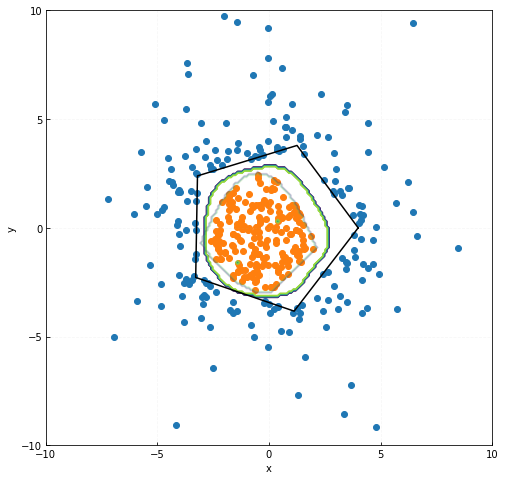

In [7]:
def experiment_classifier(n_samples=200):
    ''' Run the experiment.
    '''
    A_mat, b_vec = get_pentagon_feasible_set()
    init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])
    dataset = shake_n_bake(A_mat, init_pt, n=n_samples, scale=2)
    infeas_pts, bd_pts = zip(*dataset)
    x, y = zip(*infeas_pts)
    feasible_pts = generate_feasible_pts(n_samples)
    
    # train SVC classifier
    all_pts = np.array(list(infeas_pts) + list(feasible_pts.T))
    targets = np.ones(len(infeas_pts) + len(feasible_pts.T))
    targets[:len(infeas_pts) - 1] = 0
    svc = SVC().fit(X=all_pts, y=targets)
    x_svc, y_svc, contour_svc, real_feas = get_mdl_contour(svc)
    
    # train GP classifier (doesn't need infeasible data)
    gmm = GaussianMixture(n_components=200).fit(feasible_pts.T)
    min_score = np.min(-1 / gmm.score_samples(feasible_pts.T))
    print('min_score = {}'.format(min_score))
    x_gmm, y_gmm, contour_gmm = get_gmm_contour(gmm, min_score)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    # plot the polyhedron lines
    xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
    ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
    ax.plot(xpoly, ypoly, markersize=0, color='black')
    # plot sampled points
    ax.scatter(x, y)
    ax.scatter(feasible_pts[0], feasible_pts[1])
    # plot contour
    ax.contour(x_svc, y_svc, contour_svc)
    ax.contour(x_gmm, y_gmm, contour_gmm, alpha=0.5)
    #plt.colorbar(cmap_gmm, shrink=0.8, extend='both')
    ax.contour(x_svc, y_svc, real_feas, alpha=0.1)
    # plot details
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
        xlim=(-10, 10),
        xticks=[-10, -5, 0, 5, 10],
        ylim=(-10, 10),
        yticks=[-10, -5, 0, 5, 10],
    )
    return fig, axs

fig, axs = experiment_classifier(n_samples=200)

[[-0.25       -0.18073879]
 [ 0.09247394 -0.29459556]
 [ 0.30855225 -0.00528569]
 [ 0.10238592  0.29130446]
 [-0.25        0.18733681]]
[-1. -1. -1. -1. -1.]
[0. 0. 0. 0. 0.]
Distance is 0.43146586586233454


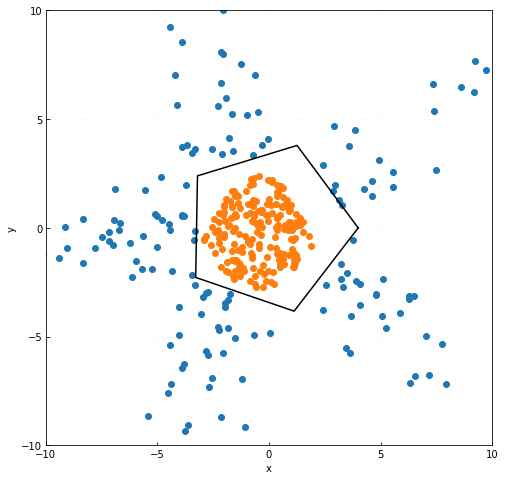

In [8]:


# now the projection algorithm
def experiment_projection(n_samples=200):
    ''' Run the experiment.
    '''
    A_mat, b_vec = get_pentagon_feasible_set()
    print(np.dot(A_mat, np.zeros(2)))
    #init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])
    #dataset = shake_n_bake(A_mat, init_pt, n=n_samples, scale=2)
    #infeas_pts, bd_pts = zip(*dataset)
    #x, y = zip(*infeas_pts)
    feasible_pts = generate_feasible_pts(n_samples)
    infeas_pts = projection_algorithm(A_mat, b_vec, feasible_pts, n_samples=n_samples, scale=20)
    dist = haussdorf(feasible_pts.T, infeas_pts)
    print('Distance is {}'.format(dist))
    x, y = zip(*infeas_pts)
    
    
    # train SVC classifier
    #all_pts = np.array(list(infeas_pts) + list(feasible_pts.T))
    #targets = np.ones(len(infeas_pts) + len(feasible_pts.T))
    #targets[:len(infeas_pts) - 1] = 0
    #svc = SVC().fit(X=all_pts, y=targets)
    #x_svc, y_svc, contour_svc, real_feas = get_mdl_contour(svc)
    
    # train GP classifier (doesn't need infeasible data)
    #gmm = GaussianMixture(n_components=1).fit(feasible_pts.T)
    #x_gmm, y_gmm, contour_gmm = get_gmm_contour(gmm)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    # plot the polyhedron lines
    xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
    ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
    ax.plot(xpoly, ypoly, markersize=0, color='black')
    # plot sampled points
    ax.scatter(x, y)
    ax.scatter(feasible_pts[0], feasible_pts[1])
    # plot contour
    #ax.contour(x_svc, y_svc, contour_svc)
    #ax.contour(x_gmm, y_gmm, contour_gmm, alpha=0.5)
    #plt.colorbar(cmap_gmm, shrink=0.8, extend='both')
    #ax.contour(x_svc, y_svc, real_feas, alpha=0.1)
    # plot details
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
        xlim=(-10, 10),
        xticks=[-10, -5, 0, 5, 10],
        ylim=(-10, 10),
        yticks=[-10, -5, 0, 5, 10],
    )
    return fig, axs

fig, axs = experiment_projection()

[[-0.    0.25]
 [-0.25 -0.25]
 [ 0.25  0.  ]]
[-1. -1. -1.]
Distance is 1.0192909756791073


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(<Figure size 576x576 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f6e8e10>,
       dtype=object))

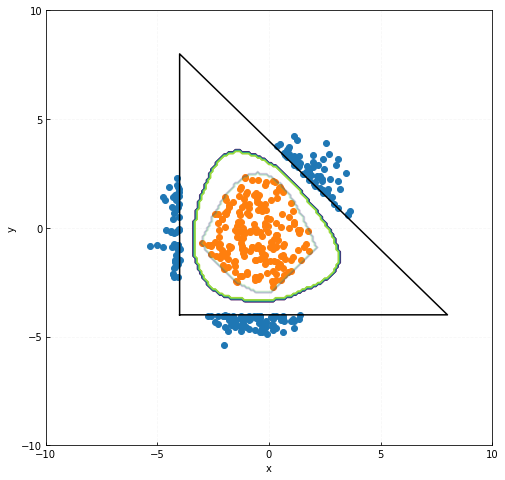

In [9]:
# now on simplex feasible set
def get_simplex_feasible_set():
    ''' Generates the A matrix and b vector by matrix inversion.'''
    X1 = np.array([
        [-4, -4],
        [8, -4],
    ])
    X2 = np.array([
        [8, -4],
        [-4, 8],
    ])
    X3 = np.array([
        [-4, 8],
        [-4, -4],
    ])
    Xs = [X1, X2, X3]
    ones = np.array([1, 1])

    A_mat = []
    b_vec = -1 * np.ones(3)
    for X in Xs:
        A_mat.append(np.linalg.solve(X, ones))
    A_mat = np.array(A_mat)
    A_mat = -1 * A_mat
    print(A_mat)
    print(b_vec)
    return A_mat, b_vec

# now the projection algorithm
def experiment_simplex_projection(n_samples=200):
    ''' Run the experiment.
    '''
    A_mat, b_vec = get_simplex_feasible_set()
    #init_pt = 0.5 * np.array([4, 0]) + 0.5 * np.array([1.26, 3.79])
    #dataset = shake_n_bake(A_mat, init_pt, n=n_samples, scale=2)
    #infeas_pts, bd_pts = zip(*dataset)
    #x, y = zip(*infeas_pts)
    feasible_pts = generate_feasible_pts(n_samples)
    infeas_pts = projection_algorithm(A_mat, b_vec, feasible_pts, n_samples=n_samples, scale=1)
    x, y = zip(*infeas_pts)
    dist = haussdorf(feasible_pts.T, infeas_pts)
    print('Distance is {}'.format(dist))
    
    # train SVC classifier
    all_pts = np.array(list(infeas_pts) + list(feasible_pts.T))
    targets = np.ones(len(infeas_pts) + len(feasible_pts.T))
    targets[:len(infeas_pts) - 1] = 0
    svc = SVC().fit(X=all_pts, y=targets)
    x_svc, y_svc, contour_svc, real_feas = get_mdl_contour(svc)
    
    # train GP classifier (doesn't need infeasible data)
    #gmm = GaussianMixture(n_components=1).fit(feasible_pts.T)
    #x_gmm, y_gmm, contour_gmm = get_gmm_contour(gmm)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    # plot the polyhedron lines
    xpoly = [-4, 8, -4, -4]
    ypoly = [-4, -4, 8, -4]
    #xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
    #ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
    ax.plot(xpoly, ypoly, markersize=0, color='black')
    # plot sampled points
    ax.scatter(x, y)
    ax.scatter(feasible_pts[0], feasible_pts[1])
    # plot contour
    ax.contour(x_svc, y_svc, contour_svc)
    #ax.contour(x_gmm, y_gmm, contour_gmm, alpha=0.5)
    #plt.colorbar(cmap_gmm, shrink=0.8, extend='both')
    ax.contour(x_svc, y_svc, real_feas, alpha=0.1)
    # plot details
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
        xlim=(-10, 10),
        xticks=[-10, -5, 0, 5, 10],
        ylim=(-10, 10),
        yticks=[-10, -5, 0, 5, 10],
    )
    return fig, axs

experiment_simplex_projection(n_samples=200)

In [10]:
# now the projection algorithm
def experiment_simplex_classifier(n_samples=200):
    ''' Run the experiment.
    '''
    A_mat, b_vec = get_simplex_feasible_set()
    init_pt = 0.5 * np.array([-4, -4]) + 0.5 * np.array([-4, 8])
    dataset = shake_n_bake(A_mat, init_pt, n=n_samples, scale=1)
    infeas_pts, bd_pts = zip(*dataset)
    x, y = zip(*infeas_pts)
    feasible_pts = generate_feasible_pts(n_samples)
    #infeas_pts = projection_algorithm(A_mat, b_vec, feasible_pts, n_samples=n_samples)
    #x, y = zip(*infeas_pts)
    dist = haussdorf(feasible_pts.T, infeas_pts)
    print('Distance is {}'.format(dist))
    
    
    # train SVC classifier
    all_pts = np.array(list(infeas_pts) + list(feasible_pts.T))
    targets = np.ones(len(infeas_pts) + len(feasible_pts.T))
    targets[:len(infeas_pts) - 1] = 0
    svc = SVC().fit(X=all_pts, y=targets)
    x_svc, y_svc, contour_svc, real_feas = get_mdl_contour(svc)
    
    # train GP classifier (doesn't need infeasible data)
    #gmm = GaussianMixture(n_components=1).fit(feasible_pts.T)
    #x_gmm, y_gmm, contour_gmm = get_gmm_contour(gmm)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    # plot the polyhedron lines
    xpoly = [-4, 8, -4, -4]
    ypoly = [-4, -4, 8, -4]
    #xpoly = [4, 1.26, -3.2, -3.28, 1.13, 4]
    #ypoly = [0, 3.79, 2.39, -2.28, -3.83, 0]
    ax.plot(xpoly, ypoly, markersize=0, color='black')
    # plot sampled points
    ax.scatter(x, y)
    ax.scatter(feasible_pts[0], feasible_pts[1])
    # plot contour
    ax.contour(x_svc, y_svc, contour_svc)
    #ax.contour(x_gmm, y_gmm, contour_gmm, alpha=0.5)
    #plt.colorbar(cmap_gmm, shrink=0.8, extend='both')
    ax.contour(x_svc, y_svc, real_feas, alpha=0.1)
    # plot details
    ax.tick_params(direction='in')
    ax.grid(True, ls='--', alpha=0.1)
    ax.set(
        xlabel='x', 
        ylabel='y', 
        xlim=(-10, 10),
        xticks=[-10, -5, 0, 5, 10],
        ylim=(-10, 10),
        yticks=[-10, -5, 0, 5, 10],
    )
    return fig, axs

experiment_simplex_classifier(n_samples=200)

[[-0.    0.25]
 [-0.25 -0.25]
 [ 0.25  0.  ]]
[-1. -1. -1.]


ValueError: True is not in list

In [ ]:
A_mat, b_vec = get_pentagon_feasible_set()


m, n = A_mat.shape
for ix in range(m):
    norm = np.linalg.norm(A_mat[ix])
    A_mat[ix] = A_mat[ix] / norm
    b_vec[ix] = b_vec[ix] / norm
print(A_mat)
print(b_vec)

x = np.zeros(2)
print(np.dot(A_mat, x) >= b_vec)
c_vec = np.ones(2)

b_relax = b_vec - np.random.exponential(5)
print(b_relax)
x = np.zeros(2)
print(np.dot(A_mat, x) >= b_relax)
c_vec = np.ones(2)


data = {
    'A_mat': A_mat,
    'b_vec': b_vec,
    'b_relax': b_relax,
    'c_vec': c_vec
}
print(data)
p = Path('../miplib/')

fname_pickle = p / 'pentagon.pickle'
with open(fname_pickle, 'wb') as f:
    pickle.dump(data, f)

In [ ]:
A_mat, b_vec = get_simplex_feasible_set()

m, n = A_mat.shape
for ix in range(m):
    norm = np.linalg.norm(A_mat[ix])
    A_mat[ix] = A_mat[ix] / norm
    b_vec[ix] = b_vec[ix] / norm
print(A_mat)
print(b_vec)

x = np.zeros(2)
print(np.dot(A_mat, x) >= b_vec)
c_vec = np.ones(2)

b_relax = b_vec - np.random.exponential(5)
print(b_relax)
x = np.zeros(2)
print(np.dot(A_mat, x) >= b_relax)
c_vec = np.ones(2)


data = {
    'A_mat': A_mat,
    'b_vec': b_vec,
    'b_relax': b_relax,
    'c_vec': c_vec
}
print(data)
p = Path('../miplib/')

fname_pickle = p / 'simplex.pickle'
with open(fname_pickle, 'wb') as f:
    pickle.dump(data, f)